In [1]:
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from gym_minigrid_navigation.utils import show_video
from utils import init_logger, switch_reproducibility_on, display_stats

init_logger('master_worker')
init_logger('train_worker')

In [3]:
from pyhocon import ConfigFactory

config = ConfigFactory.parse_file('../conf/minigrid_navigation_mlp_master_worker.hocon')
config['env']['video_path'] = './video/'

In [4]:
switch_reproducibility_on(config['seed'])

# Train worker

In [5]:
import train_worker

In [6]:
env = train_worker.gen_navigation_env(config['env'])

In [7]:
worker_agent = train_worker.get_agent(config)

In [8]:
scores, steps = train_worker.run_episodes(env, worker_agent, n_episodes=1000, verbose=config['training.verbose'])

2021-04-02 15:31:15,792 INFO    train_worker           : Episode: 100. scores: -12.43, steps: 132.57, achieved: 0.75
2021-04-02 15:32:04,136 INFO    train_worker           : Episode: 200. scores: -8.50, steps: 94.78, achieved: 0.89
2021-04-02 15:32:43,484 INFO    train_worker           : Episode: 300. scores: -6.91, steps: 78.66, achieved: 0.87
2021-04-02 15:33:15,264 INFO    train_worker           : Episode: 400. scores: -5.83, steps: 68.22, achieved: 0.90
2021-04-02 15:33:42,232 INFO    train_worker           : Episode: 500. scores: -4.72, steps: 57.53, achieved: 0.94
2021-04-02 15:33:58,791 INFO    train_worker           : Episode: 600. scores: -2.46, steps: 35.18, achieved: 0.96
2021-04-02 15:34:17,140 INFO    train_worker           : Episode: 700. scores: -2.83, steps: 38.99, achieved: 0.97
2021-04-02 15:34:29,588 INFO    train_worker           : Episode: 800. scores: -1.56, steps: 26.45, achieved: 0.99
2021-04-02 15:34:42,874 INFO    train_worker           : Episode: 900. scores:

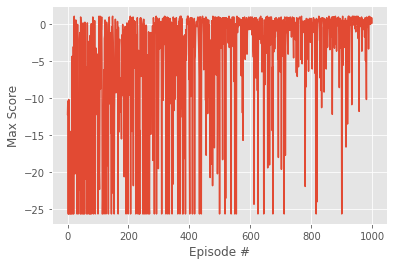

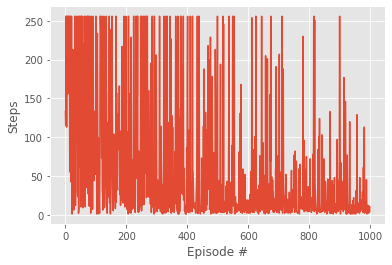

In [9]:
display_stats(scores, steps)

# Train master

In [10]:
def run_episode(env, worker_agent):
    """
    A helper function for running single episode
    """
    state = env.reset()

    score, steps, done = 0, 0, False
    while not done:
        steps += 1
        action = worker_agent.act(state, state, None)
        next_state, reward, done, _ = env.step(action)
        score += reward
        worker_agent.update(state, state, action, reward, next_state, done)
        state = next_state

    worker_agent.reset_episode()
    env.close()

    return score, steps


def run_episodes(env, worker_agent, n_episodes=1_000, verbose=False):
    """
    Runs a series of episode and collect statistics
    """
    score_sum, step_sum = 0, 0
    scores, steps = [], []
    for episode in range(1, n_episodes + 1):
        score, step = run_episode(env, worker_agent)
        score_sum += score
        step_sum += step
        scores.append(score)
        steps.append(step)

        if verbose and episode % int(verbose) == 0:
            avg_score = score_sum / int(verbose)
            avg_step = step_sum / int(verbose)
            print(f"Episode: {episode}. scores: {avg_score:.2f}, steps: {avg_step:.2f}")
            score_sum, step_sum, goals_achieved_sum, losses = 0, 0, 0, []

    return scores, steps

In [11]:
config = ConfigFactory.parse_file('../conf/minigrid_navigation_mlp_master_worker.hocon')
del config['env']['goal_achieving_criterion']
del config['env']['goal_type']

In [12]:
import torch.optim as optim

for param in worker_agent.qnetwork_local.worker.parameters():
    param.requires_grad = False
        
trainable = filter(lambda p: p.requires_grad, worker_agent.qnetwork_local.parameters())
worker_agent.optimizer = optim.Adam(trainable, lr=1e-4)

In [13]:
env = train_worker.gen_env(config['env'])

In [14]:
scores, steps = run_episodes(env, worker_agent, n_episodes=1000, verbose=config['training.verbose'])

Episode: 100. scores: 0.34, steps: 175.03
Episode: 200. scores: 0.68, steps: 88.16
Episode: 300. scores: 0.30, steps: 183.87
Episode: 400. scores: 0.13, steps: 225.64
Episode: 500. scores: 0.09, steps: 233.23
Episode: 600. scores: 0.02, steps: 251.83
Episode: 700. scores: 0.00, steps: 256.00
Episode: 800. scores: 0.02, steps: 252.52
Episode: 900. scores: 0.00, steps: 256.00
Episode: 1000. scores: 0.00, steps: 256.00


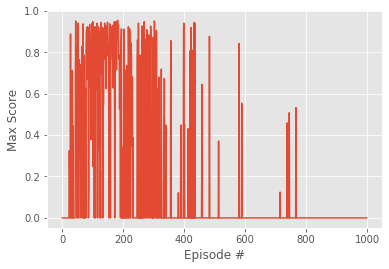

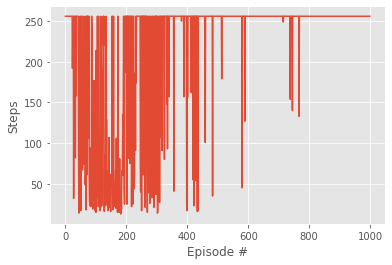

In [15]:
display_stats(scores, steps)